<a href="https://colab.research.google.com/github/paulosestini/DeepTransferLearning/blob/main/DeepTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Transfer Learning

## Motivação
Imagine que você precisa de um modelo para resolver uma tarefa, porém treinar o modelo para isso demanda muito poder computacional e tempo. Seria interessante encontrarmos uma forma de conseguir um modelo treinado para nossa tarefa mais rapidamente, e uma técnica para atingir este objetivo é a transfer learning.

## O que é Transfer Learning?
Da mesma forma que nós, humanos, conseguimos generalizar nosso aprendizado, aplicando conhecimento que nós temos em uma tarefa pra resolver outra tarefa, também é possível fazer isto com modelos de inteligência artficial.

Na técnica de transfer learning, nós transferimos o que um modelo aprendeu de um certa tarefa A para uma tarefa B, fazendo somente alguns ajustes e realizando um treinamento mais leve para adequar o conhecimento já aprendido à nova tarefa.

## Como o Transfer Learning é feito?
Existem diversos tipos de transfer learning, neste notebook iremos focar no *model-based transfer learning*, que consiste em transferir parâmetros de um modelo pré-treinado para um novo modelo.

## Exemplo com redes neurais em um problema de classificação
Neste notebook, iremos utilizar redes neurais convolucionais para transferir aprendizado de uma tarefa A para uma tarefa B.

Tarefa A -> Classificar 1000 diferentes classes em imagens, no dataset da competição ImageNet

Tarefa B -> Classificar fotos de flores, em um dataset com 5 classes de flores

Vamos usar uma rede neural já treinada para a tarefa A, e aproveitar o conhecimento dela para resolver uma tarefa parecida.

ImageNet: http://www.image-net.org/
### Imagens do dataset da ImageNet:
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/Sample-of-Images-from-the-ImageNet-Dataset-used-in-the-ILSVRC-Challenge.png" width="500"/>


## Modelo que iremos utilizar
Iremos usar uma rede convolucional do tipo VGG. Há diversos modelos de VGG, de diferentes tamanhos, neste caso iremos utilizar a VGG11, que é a VGG que possui 11 camadas treináveis (que possuem pesos).
![VGG11](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/VGG_structure.jpg/700px-VGG_structure.jpg)

Este rede que iremos treinar foi pré-treinada no dataset da ImageNet, que possui 1000 classes, portanto é importante notar os seguintes pontos:

* A camada final da rede possui 1000 neurônios, 1 para cada classe, como nosso dataset possui 5 classes, precisaremos trocar a camada final.
* A rede foi treinada com imagens de tamanho 224x224, portanto precisaremos ajustar nossas imagens este tamanho.

A biblioteca utilizada para criação do modelo será a PyTorch, que já conta com o modelo pré-treinado disponível para download.

In [ ]:
# import das bibliotecas necessárias
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd '/content/drive/My Drive/data_flowers'

/content/drive/My Drive/data_flowers


# Dataset de flores
O Dataset utilizado está disponível e pode ser baixado no kaggle: https://www.kaggle.com/alxmamaev/flowers-recognition

Ele é constituido de 4242 imagens de flores de 5 tipos diferentes:

* Margarida
* Dente de Leão
* Rosa
* Girassol
* Tulipa

Vamos dar uma olhada em algumas imagens do dataset e em seguida importar ele por completo.


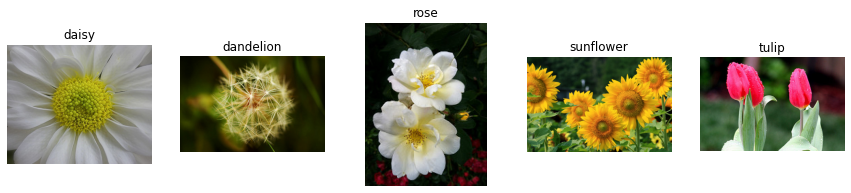

In [ ]:
# Importando uma imagem de cada tipo de flor
# e exibindo as imagens
daisy = (Image.open('./dataset/flowers/daisy/100080576_f52e8ee070_n.jpg'), 'daisy')
dandelion = (Image.open('./dataset/flowers/dandelion/10043234166_e6dd915111_n.jpg'), 'dandelion')
rose = (Image.open('./dataset/flowers/rose/10090824183_d02c613f10_m.jpg'), 'rose')
sunflower = (Image.open('./dataset/flowers/sunflower/1008566138_6927679c8a.jpg'), 'sunflower')
tulip = (Image.open('./dataset/flowers/tulip/100930342_92e8746431_n.jpg'), 'tulip')
             
flowers = [daisy, dandelion, rose, sunflower, tulip]

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
i = 0
for flower, name in flowers:
    ax[i].imshow(flower)
    ax[i].set_title(name)
    ax[i].axis('off')
    i += 1

In [ ]:
# Agora vamos importar o dataset e dividir em uma parte de treino e uma de teste

dataset = datasets.ImageFolder('dataset/flowers/flowers')

len_train_set = int(0.8*len(dataset))
len_test_set = len(dataset) - len_train_set

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])

# Olhando o tamanho do dataset e de cada parte
print(f"The dataset size is: {len(dataset)}")
print(f"The training dataset size is: {len(train_dataset)}")
print(f"The testing dataset size is: {len(test_dataset)}")

The dataset size is: 4323
The training dataset size is: 3458
The testing dataset size is: 865


# DataLoader e transformações

Para passar o dataset para nossa rede neural, precisamos colocá-lo
num objeto da biblioteca PyTorch da classe DataLoader, que cuidará
de realizar transformações nas imagens e separará o dataset em minibatchs

As transformações que precisamos realizar são as seguintes:

* Fazer o resize da imagem para 224x224 (formato de entrada para a VGG)
* Transformar as imagens em tensores de PyTorch
* Normalizar as imagens de acordo com uma média e desvio padrão requeridos pela VGG
    * mean = [0.485, 0.456, 0.406]
    * std = [0.229, 0.224, 0.225]

Obs: As informações sobre o formato das imagens de entrada para a VGG podem ser encontradas aqui: https://pytorch.org/hub/pytorch_vision_vgg/

In [ ]:
# Definindo as transformações
transform = transforms.Compose([    
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])


# Aplicando as transformações nos datasets de treino e teste
train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Criando os dataloaders de treino e teste
# Junto com a criação dos dataloaders, já definimos o tamanho dos batchs
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=64,
                                               shuffle=False,
                                               num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=64,
                                               shuffle=False,
                                               num_workers=1)


# Importando a rede pré-treinada e fazendo ajustes

Iremos importar a rede pré-treinada e fazer os seguintes ajustes:
* Alterar a camada final para dar uma predição para 5 classes em vez de 1000
* "Congelar" as camadas convolucionais da rede para que seus pesos não sejam alterados, iremos apenas retreinar as camadas densas no final da rede.

In [ ]:
# Vamos importar a rede e olhar sua arquitetura
pretrained_net = models.vgg11(pretrained=True)
print(pretrained_net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Vemos que a rede é composta por 3 módulos
* features - que contém as camadas convolucionais
* avgppol - que possui uma única camada de pooling
* classifier - que possui camadas densas

Nós iremos congelar módulo feature e iremos substituir a camada final do classifier.

In [ ]:
# Congelando os módulos features
for param in pretrained_net.features.parameters():
    param.requires_grad = False

# Alterando a camada final
pretrained_net.classifier[6] = nn.Linear(4096, 5)

# Se imprimirmos o módulo classifier, agora iremos ver
# que a última camada está ajustada, com 5 neurônios de saída.
print(pretrained_net.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [ ]:
# Também precisamos decidir onde o PyTorch fará seus cálculos.
# Se disponível, iremos utilizar a GPU.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrained_net = pretrained_net.to(device)

## Criação da função de treino e realização do treinamento

In [ ]:
def train(model, epochs, lr=0.001, weight_decay=5e-4, print_during_epoch=True):
    """
    Treina o modelo e retorna o modelo treinados e o registro das losses
    """
    
    # Otimizador e função de custo
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Treinando o modelo
    data_size = len(train_dataset)
    losses = []
    
    for epoch in range(epochs):
        examples_processed = 0
        current = 0
        correct_pred = 0

        for batch, target in train_dataloader:
            # Propagação e retropropagação
            X, y = batch.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss)
            
            # Realizando predições
            _ ,pred_labels = torch.max(out, axis=1)
            correct_pred += (pred_labels == y).sum().item()
            
            current += 1
            examples_processed += len(batch)
            if not (current % 1) and print_during_epoch:
                print(f"Epoch {epoch+1}: percentage: {100*examples_processed/data_size:.2f}% | loss: {loss:.2f} | accuracy: {100*correct_pred/examples_processed:.2f}%")

        print(f"Epoch {epoch+1}: Percentage: 100%", end='')
        print(f" | Accuracy: {100*correct_pred/examples_processed:.2f}%")
    
    return model, losses

In [ ]:
# Treinando o modelo
fine_tuned_net, fine_tuned_losses = train(pretrained_net,
                                          epochs=5,
                                          lr=0.8e-3,
                                          weight_decay=1e-3,
                                          print_during_epoch=True)

Epoch 1: percentage: 1.85% | loss: 1.84 | accuracy: 9.38%
Epoch 1: percentage: 3.70% | loss: 1.19 | accuracy: 38.28%
Epoch 1: percentage: 5.55% | loss: 0.94 | accuracy: 43.23%
Epoch 1: percentage: 7.40% | loss: 1.40 | accuracy: 43.75%
Epoch 1: percentage: 9.25% | loss: 1.28 | accuracy: 47.50%
Epoch 1: percentage: 11.10% | loss: 0.65 | accuracy: 51.30%
Epoch 1: percentage: 12.96% | loss: 1.35 | accuracy: 51.12%
Epoch 1: percentage: 14.81% | loss: 0.75 | accuracy: 53.71%
Epoch 1: percentage: 16.66% | loss: 0.91 | accuracy: 55.73%
Epoch 1: percentage: 18.51% | loss: 1.40 | accuracy: 55.94%
Epoch 1: percentage: 20.36% | loss: 0.61 | accuracy: 57.39%
Epoch 1: percentage: 22.21% | loss: 0.40 | accuracy: 59.77%
Epoch 1: percentage: 24.06% | loss: 0.70 | accuracy: 60.70%
Epoch 1: percentage: 25.91% | loss: 1.23 | accuracy: 60.83%
Epoch 1: percentage: 27.76% | loss: 0.62 | accuracy: 61.88%
Epoch 1: percentage: 29.61% | loss: 0.70 | accuracy: 63.09%
Epoch 1: percentage: 31.46% | loss: 0.88 | acc

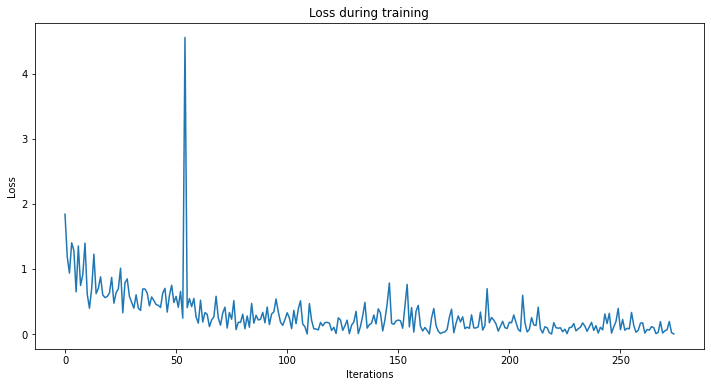

In [ ]:
# Plotando as losses ao decorrer do treinamento
def plot_losses(losses):
    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Loss during training")
    plt.show()
    
plot_losses(fine_tuned_losses)

In [ ]:
# Vendo a acurácia no dataset de teste
def evaluate_test_accuracy(model):
    test_dataset_size = len(test_dataset)
    correct_pred = 0
    for batch, target in test_dataloader:
        X, y = batch.to(device), target.to(device)
        out = model(X)

        _, pred_labels = torch.max(out, axis=1)
        correct_pred += (pred_labels == y).sum().item()

    print(f"Test accuracy: {100*correct_pred/test_dataset_size:.2f}%")

evaluate_test_accuracy(fine_tuned_net)

Test accuracy: 84.74%
